# Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
os.getcwd()

'/Users/christellejoseph/code/Cyber_Tools/IDS'

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate

from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

from imblearn.over_sampling import SMOTE
from collections import Counter

In [5]:
csv_path = '/Users/christellejoseph/code/Cyber_Tools/IDS/data'
file_dir = os.listdir(csv_path)

In [6]:
csv_files = []
for file in file_dir:
    modified_file = file.replace('-WorkingHours', '').replace('-workingHours', '').replace(
                                        '-Afternoon', '').replace('-Morning', '').replace('.pcap_ISCX.csv', '')
    csv_files.append(modified_file)

# Merging: Dictionary Structure

In [7]:
data = {}

for name, filename in sorted(zip(csv_files, file_dir)):
    data[name] = pd.read_csv(os.path.join(csv_path, filename))

In [8]:
data['Monday'].head(2)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,49188,4,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


# Merging: Single DataFrame

In [9]:
all_data = pd.concat([pd.read_csv(os.path.join(csv_path, file)) for file in file_dir], ignore_index=True)

In [10]:
all_data.shape

(2830743, 79)

In [11]:
all_data.columns = all_data.columns.str.strip()

In [12]:
cat_value_count = all_data['Label'].value_counts()

In [13]:
all_data['Label'] = all_data['Label'].str.replace('�', '-', regex=False)


In [14]:
# all_data.to_csv('combined_df.csv', index=False)

In [15]:
# all_data = all_data.drop_duplicates()

In [16]:
all_data.shape

(2830743, 79)

In [17]:
# all_data.isna().sum().sort_values(ascending=False)

In [18]:
all_data = all_data.dropna(axis=1, how='any')

# Category Visualization

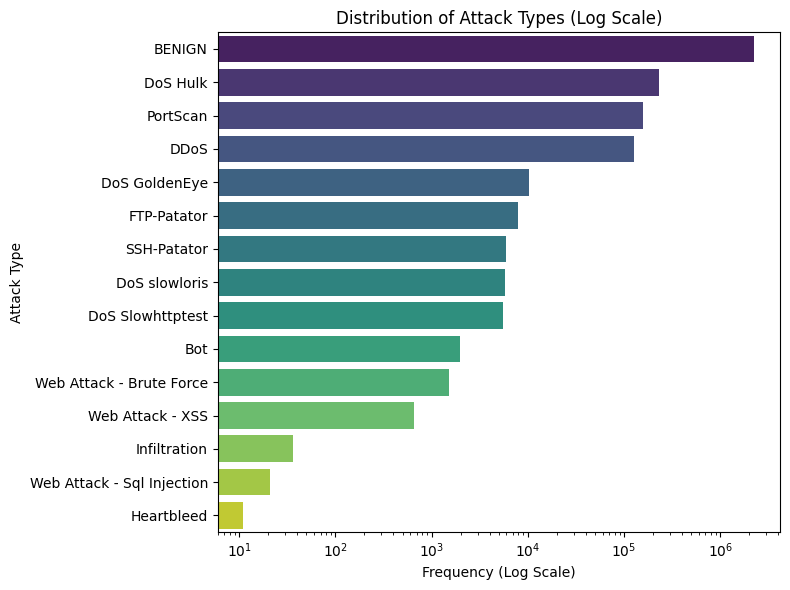

In [183]:
plt.figure(figsize=(8, 6))
label_counts = all_data['Label'].value_counts().sort_values(ascending=False)
ax = sns.countplot(y='Label', data=all_data, palette='viridis', order=label_counts.index)

# Set the scale of x-axis to log to better visualize the differences
ax.set_xscale('log')
plt.title('Distribution of Attack Types (Log Scale)')
plt.xlabel('Frequency (Log Scale)')
plt.ylabel('Attack Type')
plt.tight_layout()
plt.show()

# Encoding

In [20]:
label_encoder = LabelEncoder()
all_data['EncodedLabel'] = label_encoder.fit_transform(all_data['Label'])
#Get the mapping for future reference
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Feature Selection & Engineering

In [178]:
df = all_data
target = 'EncodedLabel'
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix to avoid duplicate correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with high correlation to remove one of a pair (above a threshold, e.g., 0.8)
to_drop_high_corr = [column for column in upper.columns if any(upper[column] > 0.8)]

# Remove features with high inter-correlation with each other
df_reduced = df.drop(to_drop_high_corr, axis=1)

# Identify features with low correlation to the target and remove them
low_corr_with_target = corr_matrix[target][(corr_matrix[target] < 0.2)].index.tolist()

# Remove features with low correlation to the target
df_final = df_reduced.drop(low_corr_with_target, axis=1, errors='ignore') # errors='ignore' to handle cases where the column might have already been removed

In [182]:
df_final.shape

(2827876, 13)

# Balancing The Dataset

In [179]:
#Solves - ValueError: Input X contains infinity or a value too large

df_final.replace([np.inf, -np.inf], np.nan, inplace=True)
df_final.dropna(inplace=True)

In [180]:
X = df_final.select_dtypes(exclude='object').drop(columns = 'EncodedLabel')
y = df_final['EncodedLabel']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

In [199]:
y_df = pd.DataFrame(y_res)